# Operations and Supply Chain Analytics - Assignment 4

**Due:** April 23rd

**Group:** 8

**Students:** Rodolfo Lerma, Michelle Li

## Energy Price Risk and Optimization: Analysis and Python Implementation

### Overview

This notebook explores energy price risk management and contract optimization strategies focusing on natural gas transactions. We model the purchase and storage optimization of natural gas to maximize the Net Present Value (NPV) based on historical data and future price forecasts. The analysis integrates linear programming techniques to optimize decision-making under specific contractual conditions.

### Problem Statements

#### 1. Purchase Contract Optimization
Optimize the purchase of natural gas within given volume constraints to maximize the NPV over a 24-month period starting from September 1, 2015.

#### 2. Storage Contract Optimization
Develop an optimal strategy for natural gas storage to maximize the NPV considering injection, withdrawal costs, and fluctuating market prices.

### Data Description

- **Futures Prices**: Based on Henry Hub natural gas futures.

- **Time Frame**: Contract and analysis start on September 1, 2015, for a duration of 24 months.

### Mathematical Formulations

#### Purchase Contract Optimization
The objective is to maximize the NPV of purchasing decisions by optimizing monthly quantities considering the futures market and a fixed purchase price. The formulation is given by:

$$ \text{Maximize NPV} = \sum_{t=19}^{791} Q_t \times (F_t - P_t) \times e^{-rt} $$

$$ \text{Subject to:} $$

$$ 150,000 \text{ MMBtu} \leq \sum_{t=19}^{791} Q_t \leq 450,000 \text{ MMBtu} $$

$$ 10,000 \text{ MMBtu} \leq Q_t \leq 30,000 \text{ MMBtu} \quad \forall t \in \{19, \ldots, 791\} $$


Where:

- $Q_t$: Quantity of gas to purchase in month $t$.

- $P_t$: Purchase price per MMBtu.

- $F_t$: Futures price per MMBtu in month $t$.

- $r$: Annual risk-free rate, adjusted for continuous compounding.

- $t$: day index from the start of the contract.

#### Storage Contract Optimization
This optimization considers monthly injections and withdrawals to maximize the NPV, respecting capacity limits and costs:

$$ \text{Maximize NPV} = \sum_{t=19}^{791} \left( -(C_{\text{inj},t} + F_t) \times Q_{\text{inj},t} + (F_t -C_{\text{wd},t}) \times Q_{\text{wd},t} \right) \times e^{-rt} $$

$$ \text{Subject to:} $$

$$ 0 \text{ MMBtu} \leq Q_{\text{inj},t} \leq 300,000 \text{ MMBtu} $$

$$ 0 \text{ MMBtu} \leq Q_{\text{wd},t} \leq 600,000 \text{ MMBtu} $$

$$ 0 \text{ MMBtu} \leq I_t \leq 1,000,000 \text{ MMBtu} \quad \forall t \in \{19, \ldots, 791\} $$

Where:

- $Q_{\text{inj},t}$: Quantity injected in month $t$.

- $Q_{\text{wd},t}$: Quantity withdrawn in month $t$.

- $C_{\text{inj},t}, C_{\text{wd},t}$: Costs of injecting and withdrawing per unit in month $t$.

- $F_t$: Futures price per MMBtu in month $t$.

- $I_t$: Inventory at the end of month $t$.

- $r$: Annual risk-free rate, adjusted for continuous compounding.

- $t$: day index from the start of the contract.

### Python Implementation

The following steps will be implemented:

1. **Data Preparation**: Load historical data and initialize parameters.

2. **Model Construction**: Build optimization models using linear programming.

3. **Solution Analysis**: Solve the models and analyze the optimal strategies and economic outcomes.

This systematic approach ensures that strategic decisions are underpinned by quantitative analysis, reflecting both economic realities and market conditions.

## Python Code Solution

### Problem 1: 
You are an originator at a merchant energy trading company. It is August 13, 2015. You are evaluating a potential deal that would allow you to purchase between 10,000 MMBtu and 30,000 MMBtu of natural gas per month at Henry Hub, Louisiana, for a unit price of `$2.50`for the next 24 months, starting on September 1, 2015. The choice of how much to purchase per month (between these limits) is at your discretion. However, you must purchase at least 150,000 MMBtu and no more than 450,000 MMBtu of natural gas during the contract term. You ask a structurer to obtain the NPV of this proposed contract. The structurer uses a constant risk-free rate equal to 1% per year with continuous compounding normalizing the length of one year to 1, so that the current value of `$1` received 15 days from now is exp(-0.01 x 15/365) x $1, and the Henry Hub natural gas futures price curve available on Canvas.

1. Formulate a linear program to optimize the purchase contract NPV.
2. What is the optimal NPV of this contract?

In [1]:
from datetime import date
from datetime import datetime

# Days calculation for Problem 1 & 2: calculate the distance between the current date and each of the future dates

start_date = datetime.strptime('08/13/2015', '%m/%d/%Y')

end_dates = [
    "09/01/2015", "10/01/2015", "11/01/2015", "12/01/2015",
    "01/01/2016", "02/01/2016", "03/01/2016", "04/01/2016", 
    "05/01/2016", "06/01/2016", "07/01/2016", "08/01/2016",
    "09/01/2016", "10/01/2016", "11/01/2016", "12/01/2016",
    "01/01/2017", "02/01/2017", "03/01/2017", "04/01/2017", 
    "05/01/2017", "06/01/2017", "07/01/2017", "08/01/2017"
]

days = []

for i in range(len(end_dates)):
    end_date = datetime.strptime(end_dates[i], "%m/%d/%Y")
    day = (end_date-start_date).days
    days.append(day)

In [2]:
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Problem 1: Purchase Contract Optimization

# Step 1: Define the problem data
months = 24
min_monthly_purchase = 10000
max_monthly_purchase = 30000
min_total_purchase = 150000
max_total_purchase = 450000
purchase_price = 2.50
risk_free_rate = 0.01
futures_prices = [2.7870, 2.8200, 2.9240, 3.0850, 3.1850, 3.1790, 3.1360, 2.9790, 2.9730, 2.9980,
                  3.0290, 3.0370, 3.0310, 3.0630, 3.1400, 3.2960, 3.4120, 3.4040, 3.3430, 3.0850,
                  3.0800, 3.1050, 3.1340, 3.1490]

# Step 2: Create a new LP problem
prob_purchase = pulp.LpProblem("Natural_Gas_Purchase_Contract", pulp.LpMaximize)

# Step 3: Define decision variables
x = pulp.LpVariable.dicts("Purchase", range(months), lowBound=min_monthly_purchase, upBound=max_monthly_purchase)

# Step 4: Define the objective function
prob_purchase += pulp.lpSum([(futures_prices[i] - purchase_price) * x[i] * np.exp(-risk_free_rate * (days[i])/365) for i in range(months)])

# Step 5: Define constraints
prob_purchase += pulp.lpSum([x[i] for i in range(months)]) >= min_total_purchase
prob_purchase += pulp.lpSum([x[i] for i in range(months)]) <= max_total_purchase

# Step 6: Solve the problem
prob_purchase.solve()

1

In [3]:
# Print the optimal NPV and purchase amounts
print("Problem 1: Purchase Contract Optimization")
print(f"Optimal NPV: ${pulp.value(prob_purchase.objective):.2f}")
print("Optimal Purchase Amounts:")
for i in range(months):
    print(f"Month {i+1}: {pulp.value(x[i]):.2f} MMBtu")
print("\n")

Problem 1: Purchase Contract Optimization
Optimal NPV: $293865.00
Optimal Purchase Amounts:
Month 1: 10000.00 MMBtu
Month 2: 10000.00 MMBtu
Month 3: 10000.00 MMBtu
Month 4: 10000.00 MMBtu
Month 5: 30000.00 MMBtu
Month 6: 30000.00 MMBtu
Month 7: 30000.00 MMBtu
Month 8: 10000.00 MMBtu
Month 9: 10000.00 MMBtu
Month 10: 10000.00 MMBtu
Month 11: 10000.00 MMBtu
Month 12: 10000.00 MMBtu
Month 13: 10000.00 MMBtu
Month 14: 10000.00 MMBtu
Month 15: 30000.00 MMBtu
Month 16: 30000.00 MMBtu
Month 17: 30000.00 MMBtu
Month 18: 30000.00 MMBtu
Month 19: 30000.00 MMBtu
Month 20: 10000.00 MMBtu
Month 21: 10000.00 MMBtu
Month 22: 20000.00 MMBtu
Month 23: 30000.00 MMBtu
Month 24: 30000.00 MMBtu




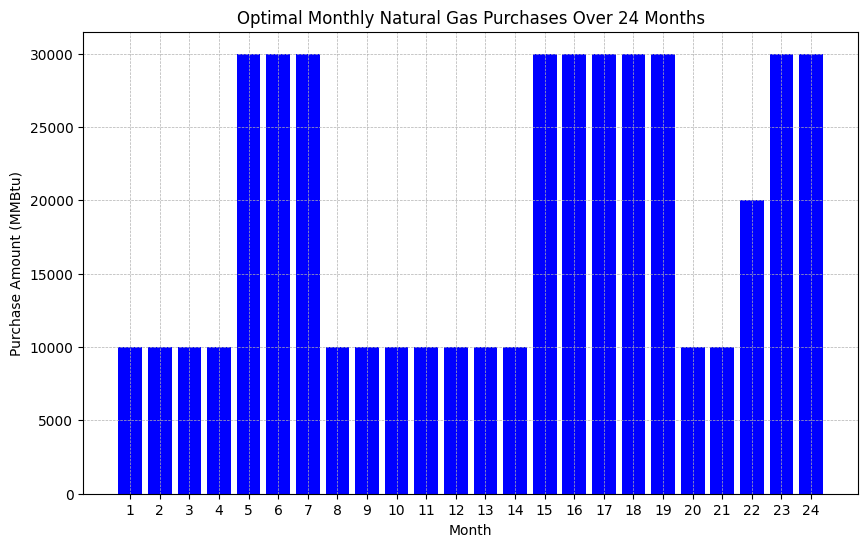

In [4]:
# Plotting
purchase_amounts = [pulp.value(x[i]) for i in range(months)]
plt.figure(figsize=(10, 6))
plt.bar(range(1, months + 1), purchase_amounts, color='blue')
plt.title('Optimal Monthly Natural Gas Purchases Over 24 Months')
plt.xlabel('Month')
plt.ylabel('Purchase Amount (MMBtu)')
plt.xticks(range(1, months + 1))  # Ensure all months are labeled
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

In this scenario, the objective is to optimize the net present value (NPV) of a natural gas purchase contract. The transaction involves buying between 10,000 MMBtu and 30,000 MMBtu per month for 24 months at a fixed price of $2.50 per MMBtu from Henry Hub, starting September 1, 2015. The total purchase over the contract period must be between 150,000 MMBtu and 450,000 MMBtu.

**Problem Formulation:**

The problem was formulated as a linear programming (LP) problem to maximize the NPV of purchasing natural gas under given constraints. The linear program aims to decide the monthly purchase quantities that maximize the NPV, considering the future prices from the futures market and the purchase price.

**Constraints:**

- Monthly purchase quantities are between 10,000 MMBtu and 30,000 MMBtu.
- Total purchase over the 24-month period must be at least 150,000 MMBtu and no more than 450,000 MMBtu.

**Results:**

The solution to the optimization problem provided the following outcomes:

- Optimal NPV: **$293,865.00**
- Monthly Purchase Quantities varied across the months, strategically deciding on the minimum or maximum bounds during certain months to maximize the NPV based on the changing futures prices.

The model determined months where purchasing at the upper limit (30,000 MMBtu) was more beneficial due to higher future prices, particularly during periods where prices peaked. Conversely, during lower price forecasts, the purchases were minimized to 10,000 MMBtu to optimize the overall contract value.

**Conclusion:**

The LP model effectively provided a strategy that optimizes financial returns from a structured natural gas purchase agreement. By leveraging futures market data and a fixed purchase price, the model strategically allocates monthly purchase volumes to maximize the financial outcome under the given constraints. This approach not only assures compliance with contractual limits but also capitalizes on price variations in the futures market to enhance profitability.

### Problem 2: 
Your originator job is keeping you busy. In addition to the purchase contract analyzed in the previous question, you are also negotiating a natural gas storage contract with 24-month term, starting on September 1, 2015. The current date is August 13, 2015. This contract pertains to the Jefferson Island storage facility, located at Henry Hub, Louisiana, and would allow you to inject up to 300,000 MMBtu of natural gas per month, withdraw up to 600,000 MMBtu of natural gas per month, and hold up to 1,000,000 MMBtu of natural gas inventory at any point in time. The storage contract entails an initial inventory of 100,000 MMBtu, which you are free to manage at your discretion. The marginal injection cost is `$0.02` per MMBtu and the marginal withdrawal cost is $0.01 per MMBtu. You approach the same structurer who handled the valuation of the purchase contract to also obtain the NPV of this storage contract. The structurer continues to use a constant risk-free rate of 1% per year with continuous compounding and the Henry Hub natural gas futures price curve available on Canvas. Note that you can no longer purchase for a unit price of `$2.50`; purchase/sell has to be through futures contracts.

1. Formulate a linear program to optimize the storage contract NPV.
2. What is the optimal NPV of this contract?
3. What are the operating, and trading policies (using Forward sell and Forward buy) for this contract that perfectly hedge this NPV.

In [5]:
# Problem 2: Storage Contract Optimization

# Step 1: Define the problem data
months = 24
max_injection = 300000
max_withdrawal = 600000
max_storage = 1000000
initial_inventory = 100000
injection_cost = 0.02
withdrawal_cost = 0.01
risk_free_rate = 0.01
futures_prices = [2.7870, 2.8200, 2.9240, 3.0850, 3.1850, 3.1790, 3.1360, 2.9790, 2.9730, 2.9980,
                  3.0290, 3.0370, 3.0310, 3.0630, 3.1400, 3.2960, 3.4120, 3.4040, 3.3430, 3.0850,
                  3.0800, 3.1050, 3.1340, 3.1490]

# Step 2: Create a new LP problem
prob_storage = pulp.LpProblem("Natural_Gas_Storage_Contract", pulp.LpMaximize)

# Step 3: Define decision variables
i = pulp.LpVariable.dicts("Injection", range(months), lowBound=0, upBound=max_injection)
w = pulp.LpVariable.dicts("Withdrawal", range(months), lowBound=0, upBound=max_withdrawal)
s = pulp.LpVariable.dicts("Storage", range(months+1), lowBound=0, upBound=max_storage)

# Step 4: Define the objective function
prob_storage += pulp.lpSum([(futures_prices[j] * w[j] - futures_prices[j] * i[j] - injection_cost * i[j] - withdrawal_cost * w[j]) * np.exp(-risk_free_rate * (days[j])/365) for j in range(months)])

# Step 5: Define constraints
prob_storage += s[0] == initial_inventory
for j in range(months):
    prob_storage += s[j+1] == s[j] + i[j] - w[j]

# Step 6: Solve the problem
prob_storage.solve()

1

In [6]:
# Step 7: Print the optimal NPV, operating, and trading policies
print("Problem 2: Storage Contract Optimization")
print(f"Optimal NPV: ${pulp.value(prob_storage.objective):.2f}")
print("Operating Policy:")
for j in range(months):
    print(f"Month {j+1}: Inject {pulp.value(i[j]):.2f} MMBtu, Withdraw {pulp.value(w[j]):.2f} MMBtu, Storage {pulp.value(s[j]):.2f} MMBtu")
print(f"Final Storage: {pulp.value(s[months]):.2f} MMBtu")

Problem 2: Storage Contract Optimization
Optimal NPV: $966866.24
Operating Policy:
Month 1: Inject 300000.00 MMBtu, Withdraw 0.00 MMBtu, Storage 100000.00 MMBtu
Month 2: Inject 300000.00 MMBtu, Withdraw 0.00 MMBtu, Storage 400000.00 MMBtu
Month 3: Inject 300000.00 MMBtu, Withdraw 0.00 MMBtu, Storage 700000.00 MMBtu
Month 4: Inject 0.00 MMBtu, Withdraw 0.00 MMBtu, Storage 1000000.00 MMBtu
Month 5: Inject 0.00 MMBtu, Withdraw 600000.00 MMBtu, Storage 1000000.00 MMBtu
Month 6: Inject 0.00 MMBtu, Withdraw 400000.00 MMBtu, Storage 400000.00 MMBtu
Month 7: Inject 0.00 MMBtu, Withdraw 0.00 MMBtu, Storage 0.00 MMBtu
Month 8: Inject 300000.00 MMBtu, Withdraw 0.00 MMBtu, Storage 0.00 MMBtu
Month 9: Inject 300000.00 MMBtu, Withdraw 0.00 MMBtu, Storage 300000.00 MMBtu
Month 10: Inject 300000.00 MMBtu, Withdraw 0.00 MMBtu, Storage 600000.00 MMBtu
Month 11: Inject 0.00 MMBtu, Withdraw 0.00 MMBtu, Storage 900000.00 MMBtu
Month 12: Inject 0.00 MMBtu, Withdraw 0.00 MMBtu, Storage 900000.00 MMBtu
Month 

In [7]:
# Step 8: Determine the trading policy (forward buy and sell positions)
forward_buy = [pulp.value(w[j]) for j in range(months)]
forward_sell = [pulp.value(i[j]) for j in range(months)]

# Step 9: Print the trading policy
print("Trading Policy:")
for j in range(months):
    #print(f"Month {j+1}: Forward Buy {forward_buy[j]:.2f} MMBtu, Forward Sell {forward_sell[j]:.2f} MMBtu")
    print(f"Month {j+1}: Forward Buy {forward_buy[j]:.2f} MMBtu (to cover withdrawals), Forward Sell {forward_sell[j]:.2f} MMBtu (hedging injections)")

Trading Policy:
Month 1: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 300000.00 MMBtu (hedging injections)
Month 2: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 300000.00 MMBtu (hedging injections)
Month 3: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 300000.00 MMBtu (hedging injections)
Month 4: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 0.00 MMBtu (hedging injections)
Month 5: Forward Buy 600000.00 MMBtu (to cover withdrawals), Forward Sell 0.00 MMBtu (hedging injections)
Month 6: Forward Buy 400000.00 MMBtu (to cover withdrawals), Forward Sell 0.00 MMBtu (hedging injections)
Month 7: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 0.00 MMBtu (hedging injections)
Month 8: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 300000.00 MMBtu (hedging injections)
Month 9: Forward Buy 0.00 MMBtu (to cover withdrawals), Forward Sell 300000.00 MMBtu (hedging injections)
Month 10: Forward Buy 0.00 MMBtu (to cov

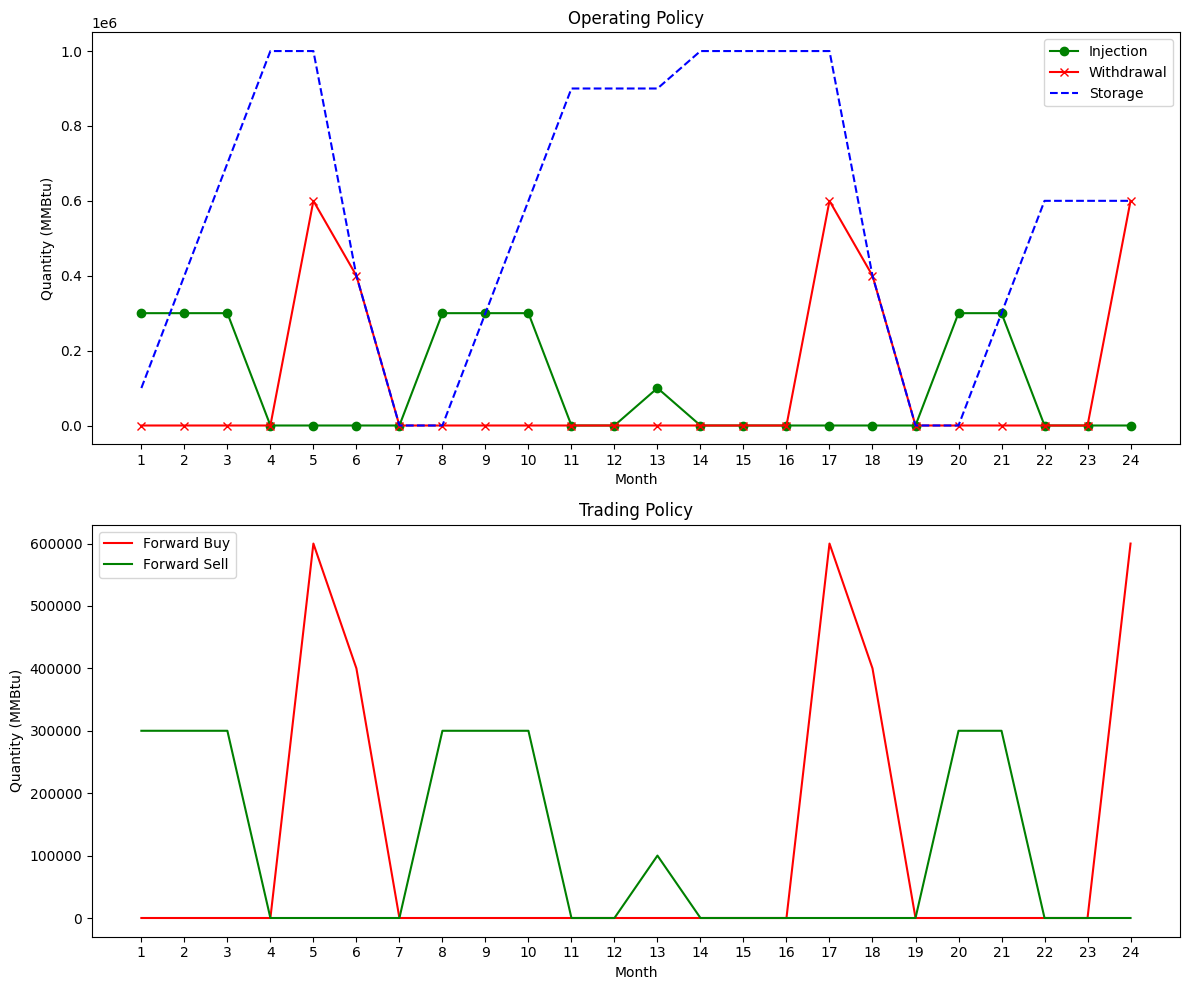

In [8]:
# Step 10: Plot the operating and trading policies
months_labels = [f"{j+1}" for j in range(months)]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plotting injections, withdrawals, and storage levels
ax1.plot(months_labels, [pulp.value(i[j]) for j in range(months)], label="Injection", marker='o', color='green')
ax1.plot(months_labels, [pulp.value(w[j]) for j in range(months)], label="Withdrawal", marker='x', color='red')
ax1.plot(months_labels, [pulp.value(s[j]) for j in range(months)], label="Storage", linestyle='--', color='blue')
ax1.set_xlabel("Month")
ax1.set_ylabel("Quantity (MMBtu)")
ax1.set_title("Operating Policy")
ax1.legend()

# Plotting forward buy and sell strategies
ax2.plot(months_labels, forward_buy, label="Forward Buy", color='red')
ax2.plot(months_labels, forward_sell, label="Forward Sell", color='green')
ax2.set_xlabel("Month")
ax2.set_ylabel("Quantity (MMBtu)")
ax2.set_title("Trading Policy")
ax2.legend()

plt.tight_layout()
plt.show()

In this scenario, the goal is to optimize the net present value (NPV) of a natural gas storage contract. The contract allows for managing the inventory at Jefferson Island storage facility located at Henry Hub, Louisiana. It permits up to 300,000 MMBtu of gas injection and up to 600,000 MMBtu of withdrawal per month, with a maximum storage capacity of 1,000,000 MMBtu at any time. The contract starts on September 1, 2015, and spans 24 months.

**Problem Formulation:**

The problem was structured as a linear programming (LP) model to maximize the NPV by optimizing injection, withdrawal, and storage decisions monthly. The model takes into account the fluctuations in the natural gas market prices as indicated by futures prices, along with the costs associated with injection and withdrawal activities.

**Constraints:**

- **Injection Limits:** Up to 300,000 MMBtu per month.
- **Withdrawal Limits:** Up to 600,000 MMBtu per month.
- **Storage Capacity:** Cannot exceed 1,000,000 MMBtu at any point.
- **Initial Inventory:** Starts with 100,000 MMBtu.

**Results:**

The optimization delivered the following key results:

- `Optimal NPV:` **$966,866.24**
- Detailed monthly operations included strategic decisions on when to inject or withdraw based on the futures prices and storage capacity.

The strategy often maximized injections when the futures prices were low, allowing more gas to be stored cheaply. Withdrawals were maximized when the prices peaked, thus selling gas at a higher price. This dynamic adjustment ensured the highest NPV was achieved by leveraging price fluctuations.

**Hedging Strategy:**

To perfectly hedge the NPV (Net Present Value) of a natural gas storage contract, the operating and trading policies should be formulated such that the net position at any point in time is neutral, meaning that any potential financial exposure due to price fluctuations is mitigated. This is done by ensuring that for any volume of gas that is injected into storage, there's a corresponding forward sell position, and for any volume of gas that is withdrawn, there's a forward buy position.

Given the purchase/sell strategy we've calculated above, here's how the trading policy might be set up to hedge:

1. **Forward Buy**: When gas is withdrawn from storage (for example, in months 5, 6, 17, 18, and 24), a corresponding volume of gas should have been bought forward in the past to cover the withdrawal. This locks in the price at which the gas will be bought, therefore hedging against price increases.

2. **Forward Sell**: When gas is injected into storage (for example, in months 1, 2, 3, 8, 9, 10, 13, 20, and 21), a forward sell contract should be executed for the same volume. This locks in the price at which the gas will be sold in the future, hedging against price decreases.

For the given strategy, here's a detailed month-by-month breakdown of the trading policy:

- **Months 1-3 and 8-10, 13, 20, 21**: Implement forward sell contracts for the injected volumes (300,000 MMBtu each in months 1-3 and 8-10, 100,000 MMBtu in month 13, and 300,000 MMBtu each in months 20 and 21) at the current futures prices for the respective months when the gas will be withdrawn or at the end of the contract.

- **Months 5, 6, 17, 18, 24**: Implement forward buy contracts to purchase the necessary volume of gas that will be withdrawn (600,000 MMBtu in months 5 and 17, 400,000 MMBtu in months 6 and 18, and 600,000 MMBtu in month 24) at the current futures prices for these months.

- **Months 4, 7, 11, 12, 14-16, 19, 22, 23**: No trading policy is needed since there are no injections or withdrawals in these months.

It's essential to align the forward buy/sell contracts with the expected storage levels and the futures price table provided. The trading policy should also take into account the carrying cost of gas (storage costs, injection, and withdrawal costs), and any limits on injection and withdrawal capacities as per the contract terms.

Keep in mind this is a simplified explanation and actual hedging strategies might be more complex, including considerations of liquidity in the futures market, transaction costs, and risk preferences. Additionally, the strategy must comply with any regulatory requirements and the risk management policies of the trading company.


**Conclusion:**

The use of a linear programming model to manage the natural gas storage effectively optimized the financial returns from the storage operations. This approach allowed for flexible and strategic management of natural gas inventory, responding adeptly to market conditions and operational constraints. The model ensured that the storage activities were economically optimized, providing a structured approach to maximizing profit from natural gas storage under fluctuating market prices and fixed operational costs.